# Here I perform multiple tests of the instrumental glitch waveform and of the code that goes along with it

In [1]:
import sys
sys.path.append("../") 

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import LISA as l

import Wavelet as wv
import Glitch as gl
import MCMC_tools as mct

# constants
mHz = 1.0e-3
Hour = 3600.

# Create a Wave Object for testing

In [2]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt

# set up the LISA orbit
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

print("Nyquist Freq........ {} mHz".format(orb.f_ny*1000.))

# set up parameters of wavelet
A    = 2.0e-20
f0   = 3.0*mHz
tau  = 10.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 0.0


Q = 2*np.pi*f0*tau
print("tau................. {} s".format(tau))
print("Q................... {} s".format(Q))
print("dt.................. {} s".format(orb.dt))

# create wave object
wave = wv.Wavelet(A, f0, tau, t0, phi0, orb)
wave.calc_Psi()
wave.make_padded_Psi(t) # drop in the wavelet time series into the data stream
h = h + wave.Psi_padded

Nyquist Freq........ 33.333333333333336 mHz
tau................. 37800.0 s
Q................... 712.5132138341651 s
dt.................. 15.0 s


# Create Glitch Object

In [3]:
print(gl.COMP_ID_LS[0])

glitch = gl.Glitch(wave, 0, orb) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch.calc_TDI()
glitch.calc_snr()
print("Glitch SNR: {}".format(glitch.SNR))

# Adjust the SNR to desired target
glitch.adjust_snr(10)
print(glitch.Wavelet.A)
print("Glitch SNR: {}".format(glitch.SNR))

OP12
Glitch SNR: 743.6345491976672
2.689493114807359e-22
Glitch SNR: 10.00000000000001


In [4]:
glitch.calc_Fish()
print(glitch.Fisher)

[[ 1.00000000e+02  1.01768527e+01  1.01512856e-04  7.99999100e+02
  -4.40482793e-08]
 [ 1.01768527e+01  1.41020986e+06  9.29515043e-03 -8.14143116e+01
   1.50692476e-06]
 [ 1.01512856e-04  9.29515043e-03  1.29959759e+10 -9.93729043e-04
  -1.13999782e+06]
 [ 7.99999100e+02 -8.14143116e+01 -9.93729043e-04  1.91999903e+04
  -1.07403361e-06]
 [-4.40482793e-08  1.50692476e-06 -1.13999782e+06 -1.07403361e-06
   9.99999997e+01]]


In [5]:

print("Numeric Fisher Estimates")
invFish = np.linalg.inv(glitch.Fisher)
print("-------------------------------")
print("A error............ {} %"      .format( 100*np.sqrt(invFish[0,0]) ))
print("f0 error........... {} mHz"    .format(     np.sqrt(invFish[1,1]) ))
print("t0 error........... {} minutes".format(     np.sqrt(invFish[2,2])*7*24*60 ))
print("tau error.......... {} minutes".format(     np.sqrt(invFish[3,3])*7*24*60 ))
print("phi0 error......... {}"        .format(     np.sqrt(invFish[4,4]) ))
print()
print("Analytic Fisher Estimates")
print("-------------------------------")

lnA_error = 1/glitch.SNR

f0_error = 1/(np.pi*glitch.SNR*glitch.Wavelet.tau)

t0_error = tau/glitch.SNR/np.sqrt(1 + (2*np.pi*f0*tau)**2)

tau_error = 2*glitch.Wavelet.tau/np.sqrt(3.)/glitch.SNR

phi0_error = 1/glitch.SNR

print("A error............ {} %"  .format(100*lnA_error))
print("f0 error........... {} mHz".format(f0_error/mHz))
print("t0 error........... {} minutes".format(t0_error/60))
print("tau error.......... {} minutes".format(tau_error/60))
print("phi0 error......... {}".format(phi0_error))

Numeric Fisher Estimates
-------------------------------
A error............ 12.247455347362981 %
f0 error........... 0.0008420901840400723 mHz
t0 error........... 63.00408926185462 minutes
tau error.......... 89.09550340457605 minutes
phi0 error......... 71.25455875880361

Analytic Fisher Estimates
-------------------------------
A error............ 9.99999999999999 %
f0 error........... 0.0008420896459888634 mHz
t0 error........... 0.08841932574627952 minutes
tau error.......... 72.74613391789278 minutes
phi0 error......... 0.0999999999999999


In [6]:
e_vals, e_vecs = mct.get_Fihser_Eignen_BS(glitch.Fisher)
print (e_vals)

[1.96958481e-04 6.65506562e+01 1.92334348e+04 1.41020987e+06
 1.29959760e+10]


# Plot the Glitch

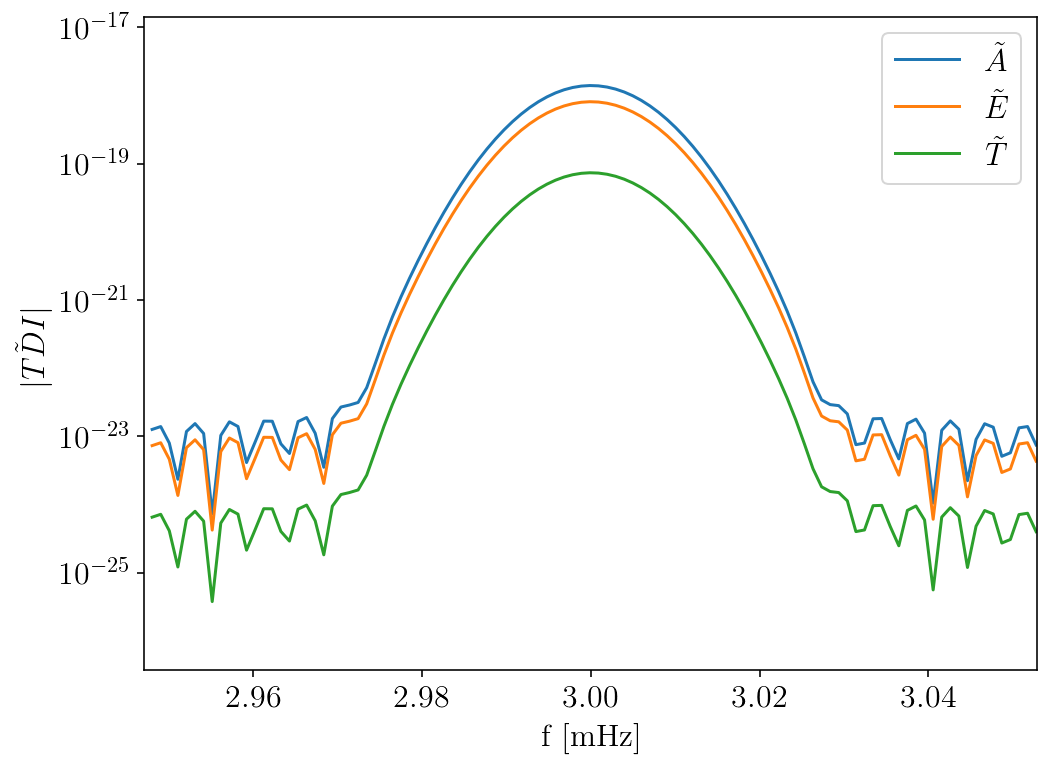

In [7]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\tilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlim(wave.f_min*1000, wave.f_max*1000)

mask = (glitch.TDI.freqs > wave.f_min) & (glitch.TDI.freqs < wave.f_max) 

f = glitch.TDI.freqs[mask]*1000

A = np.abs(glitch.TDI.A[mask])
E = np.abs(glitch.TDI.E[mask])
T = np.abs(glitch.TDI.T[mask])

y_vals = []

if (len(A[(A != 0.0)]) != 0):
    y_vals.append(A)
    ax.semilogy(f, A, label=r'$\tilde{A}$')

if (len(E[(E != 0.0)]) != 0):
    y_vals.append(np.abs(glitch.TDI.E[mask]))
    ax.semilogy(f, E, label=r'$\tilde{E}$')

if (len(T[(T != 0.0)]) != 0):
    y_vals.append(T)
    ax.semilogy(f, T, label=r'$\tilde{T}$')
    
y_min = 0.1*np.min(y_vals)
y_max = 10.*np.max(y_vals)

ax.set_ylim(y_min, y_max)
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

# Look at signal in time domain

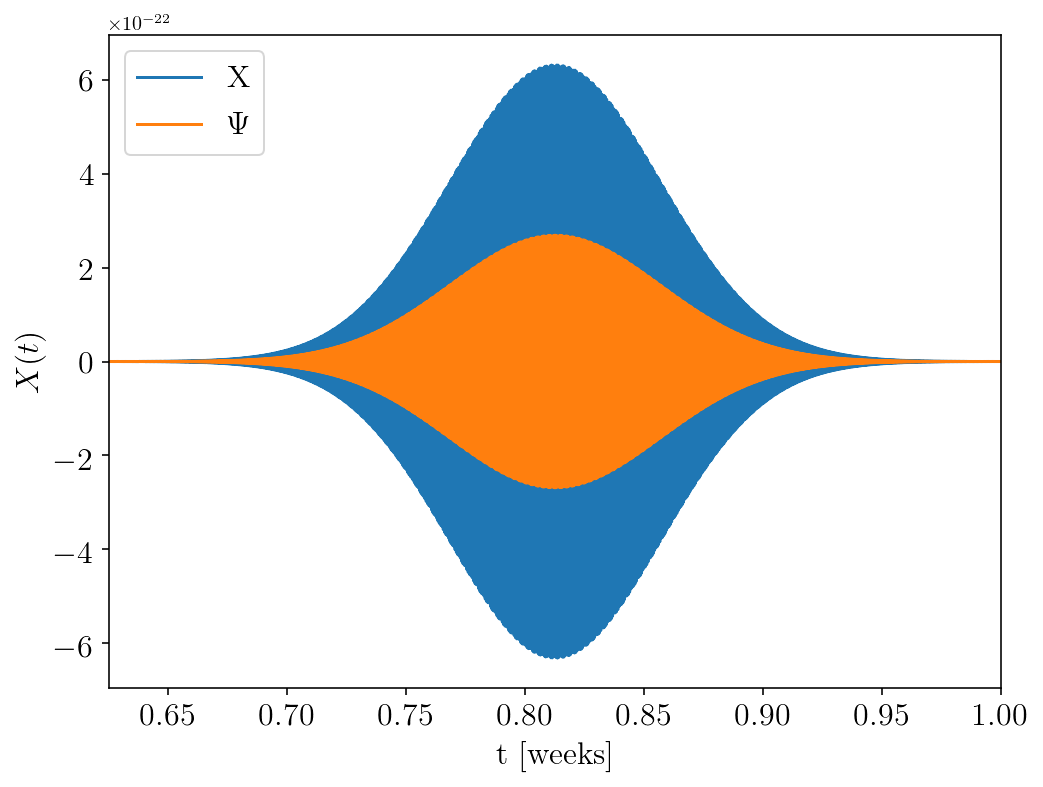

In [8]:
X_time_dom = np.fft.irfft(glitch.TDI.X)

fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r't [weeks]', fontsize=16)
ax.set_ylabel(r'$X(t)$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.xlim((wave.t0 - 3.*wave.tau)/Week, (wave.t0 + 3.*wave.tau)/Week)
glitch.SNR**2
ax.plot(t[1:-1]/Week, X_time_dom, label=r'X')
ax.plot(wave.t/Week, wave.Psi.real, label=r'$\Psi$')

plt.legend(loc='upper left', fontsize=16)

plt.show()

# Analytic Check

In [9]:
# I forgot how I did the check, but I did...
#     saving this for potential future use
def get_Psi_FT(f, Wavelet):
    term1 = np.exp(2.j*Wavelet.phi0)
    term2 = np.exp(-(f - Wavelet.f0)**2*np.pi**2*Wavelet.tau**2)
    term3 = np.exp(-(f + Wavelet.f0)**2*np.pi**2*Wavelet.tau**2) + term1*term2
    term4 = np.exp(-1.0j*(2.0*np.pi*f*Wavelet.t0 + Wavelet.phi0))
    
    return np.sqrt(np.pi)/2.*Wavelet.A*Wavelet.tau*term4*term3

In [14]:
1.25*1250

1562.5